Force Sensor

In [1]:
import nidaqmx 
import atiiaftt as ati
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CALFILEPATH = "FT44764\FT44764.cal"
INDEX = 1

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()
    reading = task.read()

transform = [0,0,0,0,0,0]

#Bias
sensor = ati.FTSensor()
cal = sensor.createCalibration(CALFILEPATH, INDEX)
sensor.setForceUnits("N".encode("utf-8"))
sensor.setTorqueUnits("N-m".encode("utf-8"))
sensor.setToolTransform(transform, "mm".encode("utf-8"), "deg".encode("utf-8"))

sensor.bias(bias)
output = sensor.convertToFt(reading)
output

[-0.00011062039993703365,
 4.1884719394147396e-05,
 0.004124949686229229,
 0.00012192424765089527,
 -6.849616329418495e-05,
 0.0002205649798270315]

Test Sensor

In [3]:
current_time = time.time()
duration = 5
readings = []
while time.time() < current_time+duration:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")

        reading = sensor.convertToFt(task.read())
        print(reading)
        readings.append(reading)

print("Number of Data", len(readings))

[-0.0022549545392394066, 0.0013623764971271157, -0.02049853466451168, 0.0001436394959455356, -3.9464852306991816e-05, 0.000288638926576823]
[-0.002396876225247979, 0.011981472373008728, 0.00840232614427805, 2.3900747692096047e-05, 9.17295619728975e-05, -0.00021086560445837677]
[-2.993689849972725e-05, 0.005366329103708267, -0.008204600773751736, 0.0001866386883193627, -6.639390630880371e-05, 7.537839701399207e-05]
[0.004642791580408812, 0.010684486478567123, -0.016417188569903374, 0.00013188178127165884, -0.00018673122394829988, 0.00014586075849365443]
[-0.00010721618309617043, 0.01340565551072359, -0.003828976536169648, 4.837136293645017e-05, -0.00034320520353503525, 0.00029526930302381516]
[-0.0001577865332365036, 0.010745054110884666, 0.008464804850518703, 1.2368738680379465e-05, -0.00034421507734805346, 0.00015173578867688775]
[-0.00456918915733695, 0.010764483362436295, -0.020236682146787643, 1.913374217110686e-05, -0.00042457148083485663, 0.0001467000984121114]
[0.002422316931188

Initiallize Motor

In [4]:
import numpy as np
import datetime as dt
import csv
import matplotlib.pyplot as plt
import serial
from time import sleep


ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

Function

In [5]:
def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [6]:
# open the serial port
ser = serial.Serial('COM4', 115200, timeout=1)


Set Zero

In [7]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Begining
Starting Zero Position M1
Starting Zero Position M2
Finishing Zero Position


Enter Motor and Re-bias Force Sensor

In [34]:
##Motor

dT = 0

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()

sensor.bias(bias)

Starting Enter Motors


Running

In [35]:
start_time = dt.datetime.today().timestamp()
t = 0
l1 = 0.275
l2 = 0.24
l4 = 0.01
q0 = np.deg2rad(18)
logs = list()
motor_logs = list()
readings = list()

t_mapping = 1/1.35

x = l1*np.sin(q1) + l2*np.cos(q2)
y = l1*np.cos(q1) - l2*np.sin(q2)

time = 0
record_duration = 20

print("Start Controling")
while time < record_duration:
    start_time = dt.datetime.today().timestamp()

    log = list()
    log.append(time)

    q1_old = q1
    q2_old = q2

    x_old = x
    y_old = y


    T1 = 0
    T2 = 0

    
    
    log.append(T1)
    log.append(T2)


    command1 = bytes(pack_cmd(0,0,-T1*t_mapping,0,0)) #(pos,vel,torque,kp,kd)
    command2 = bytes(pack_cmd(0,0,T2*t_mapping,0,0)) #(pos,vel,torque,kp,kd)

    #M1
    ser.write(bytes([0x01])+command1)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    #M2
    ser.write(bytes([0x02])+command2)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    log.append(t1)
    log.append(t2)

    log.append(q1)
    log.append(q2)

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    log.append(x)
    log.append(y)

    if time!= 0:
        x_dot = (x-x_old)/dT
        y_dot = (y-y_old)/dT
    
    else:
        x_dot = 0
        y_dot = 0

    log.append(x_dot)
    log.append(y_dot)

    #Estimate CF
    A = q0-q1+2*q2
    B = q0-q1
    C = q0-2*q1+q2
    D = q0+q2
    Fx = -((T1*l2*(np.sin(A)+np.sin(B))+T2*l1*(np.sin(C)-np.sin(D)))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))
    Fy = (T1*l2*(np.cos(B)+np.cos(C))+T2*l1*(np.cos(D)-np.cos(A))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))    

    log.append(Fx)
    log.append(Fy)

    motor_logs.append(log)


    #Sensor
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
        reading = sensor.convertToFt(task.read())

  
    #print(reading)
    
    readings.append(reading)

    log.append(-reading[0])
    log.append(-reading[1])

    logs.append(log)
    
    # print("Progress", f'{round(time/record_duration*100,3)}%')
    dT = dt.datetime.today().timestamp()-start_time
    time+= dT

ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()
    

print("finish")
# print(logs)


Start Controling
finish


Emergency Exit

In [ ]:
ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()


In [36]:
##readings

print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

print(df)


##logs
print(logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "x_dot", "y_dot", "Fx", "Fy", "Fx_Mea", "Fy_Mea"]

logs_arrays = np.array([np.array(item) for item in logs])

logs_arrays_transpose = logs_arrays.transpose()
df_log = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df_log[logs_COLUMNS[i]] = logs_arrays_transpose[i]

print(df_log)

Data Sample Size 609
      Force X   Force Y   Force Z  Torque X  Torque Y  Torque Z
0   -3.035737  2.046706 -0.597774 -0.003215 -0.066935 -0.010177
1   -2.561394  0.078522 -0.876956 -0.013539 -0.122471 -0.001222
2   -1.555667  1.737730 -1.142317  0.011507  0.006730 -0.010111
3   -2.053362  1.748844 -0.468030 -0.059443 -0.073754  0.017418
4   -0.708819  0.729978 -0.590213  0.036519 -0.015763 -0.017651
..        ...       ...       ...       ...       ...       ...
604  0.113344  2.348975 -0.416395 -0.011979  0.038180 -0.003144
605  0.699497  2.542236 -0.726550  0.031465  0.103551 -0.011055
606 -0.139090 -0.285955  0.230965 -0.062059 -0.039174 -0.000315
607  2.669222 -0.406215 -0.186747  0.042584  0.063554 -0.005360
608  1.406162  2.301694 -0.093318 -0.053359  0.066658 -0.006570

[609 rows x 6 columns]
[[0, 0, 0, -0.008241758241758212, 0.008241758241758212, 0.549, 0.97, 0.27917635936043605, 0.036615294107023494, 0, 0, -0.0, 0.0, -2.046706438064575, 3.0357370376586914], [0.02800107002258

In [37]:
df_log.to_csv("Joey/Record_Data/T1_00_T2_00_3.csv")

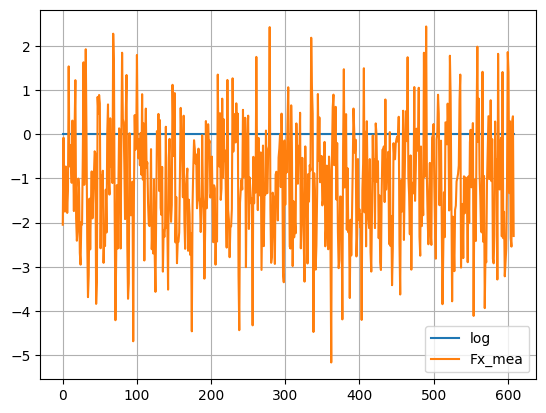

In [38]:
X = df_log.index
Y = df_log["Fx"]
plt.plot(X, Y, label="log")
plt.grid()
plt.plot(X, df_log["Fx_Mea"], label="Fx_mea")
plt.legend()